In [650]:
import pandas as pd
import numpy as np
import nltk
from sklearn.linear_model import LogisticRegressionCV, LassoCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, precision_recall_curve,average_precision_score, roc_auc_score, \
roc_curve, auc, f1_score
from sklearn import preprocessing
from sklearn.utils.multiclass import unique_labels
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.utils.fixes import signature

In [516]:
def clean_text(s):
    stripped = re.sub('[^\w\s]', '', s)
    stripped = re.sub('_', '', stripped)
    stripped = re.sub("\d+", " ", stripped)
    stripped = re.sub('\s+', ' ', stripped)
    stripped = stripped.strip()
    
    return stripped.lower()

In [658]:
df = pd.read_csv('abstract_pred.csv')
df.dtypes

id         int64
target     int64
text      object
dtype: object

In [593]:
df.head()
Counter(df['target'])

# clean text
df['text'] = df.text.apply(lambda x: clean_text(x))


In [595]:
tfidf = TfidfVectorizer(norm='l2',min_df=0, use_idf=True, smooth_idf=False, analyzer='word',
                        sublinear_tf=True, stop_words = 'english')
tfidf_matrix = tfidf.fit_transform(df['text'])

doc = 2
feature_names = tfidf.get_feature_names()
feature_index = tfidf_matrix[doc,:].nonzero()[1]
tfidf_scores = zip(feature_index, [tfidf_matrix[doc, x] for x in feature_index])

for w, s in [(feature_names[i], s) for (i, s) in tfidf_scores]:
    print(w, s)

In [566]:
## drop columns that are common in all the text
drop_list = []
for i in feature_index:
    drop_list.append(feature_names[i])

In [613]:
# create matrix with tf-idf method
tf_idf_matrix = pd.DataFrame(tfidf_matrix.toarray(), columns = tfidf.get_feature_names())
tf_idf_matrix.shape
text_relevant = tf_idf_matrix.drop(columns = drop_list)

text_relevant.shape


y = df.target
X = text_relevant

X['length'] = preprocessing.normalize([df.text.apply(lambda x: len(x)).values])[0]
X.head()

,aalone,abdominal,abeneficial,ability,abnormal,abnormalities,abnormalitiesthe,abstinencerates,abstract,according,...,women,words,worsening,written,xanthine,xo,years,york,young,length
0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.161063
1,0.0,0.0,0.0,0.136922,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.110314
2,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.200057
3,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.128149,0.0,0.0,0.159368
4,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.113931


### Models

In [614]:
RF = RandomForestClassifier(n_estimators=400, criterion='gini', max_depth=None, min_samples_split=2, 
                       min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', 
                       max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, 
                       bootstrap=True, oob_score=False, n_jobs=None, random_state=None, verbose=0, 
                       warm_start=False, class_weight=None)
svm = SVC(C=1.0, kernel= 'rbf', degree=3, gamma='auto_deprecated', coef0=0.0, shrinking=True, probability=True, 
          tol=0.001, cache_size=200, class_weight=None, verbose=False, max_iter=-1, decision_function_shape='ovr',
          random_state=None)
Logistic =  LogisticRegressionCV(Cs=[0.1, 0.3, 1, 3, 10], fit_intercept=True, cv=5, dual=False, penalty='l2', scoring=None, solver='lbfgs', 
             tol=0.0001, max_iter=100, class_weight=None, n_jobs=None, verbose=0, refit=True, 
             intercept_scaling=1.0, multi_class='ovr', random_state=None)

In [615]:
model = RF

model.fit(X, y)
model.score(X, y)

1.0

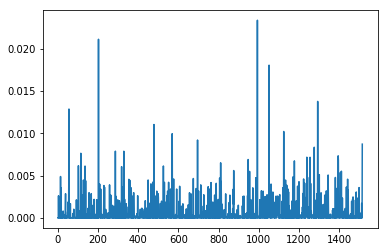

In [616]:
plt.plot(model.feature_importances_)

In [617]:
X.shape

(31, 1516)

In [715]:
## select features with RF
threshold =  0.006

drop_list1 = list(X.columns[model.feature_importances_ < threshold])
drop_list1

if 'cardiovascular' in drop_list1:
    drop_list1.remove('cardiovascular')

X = X.drop(drop_list1, axis = 1)


In [716]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 12)

sm = SMOTE(random_state = 12, k_neighbors = 3)
x_train_res, y_train_res = sm.fit_sample(X_train, y_train)


In [717]:
model = RF

model.fit(X_train, y_train)
print(model.score(X_train, y_train))
print(model.score(X_test, y_test))
model.predict_proba(X_test)[:,1]

1.0
0.9


array([0.0475, 0.015 , 0.29  , 0.2   , 0.2325, 0.175 , 0.0475, 0.1025,
       0.0725, 0.1225])

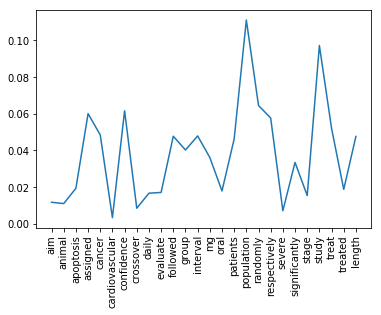

In [718]:
plt.plot(model.feature_importances_)
plt.xticks(range(len(model.feature_importances_)), X.columns, rotation = 90)
plt.show()

Precision measures among the predictions the algorithm classified as positive, what fraction are correct. $precision = \frac{TP}{TP + FP}$<br>
Recall is of all the positive labels, the fraction the algorithm correctly detect as positive. $recall = \frac{TP}{TP + FN}$

In [719]:
precision, recall, _ = precision_recall_curve(y_test, model.predict_proba(X_test)[:, 1])
precision, recall
roc_auc_score(y_test, model.predict_proba(X_test)[:,1])
average_precision = average_precision_score(y_test, model.predict_proba(X_test)[:, 1])

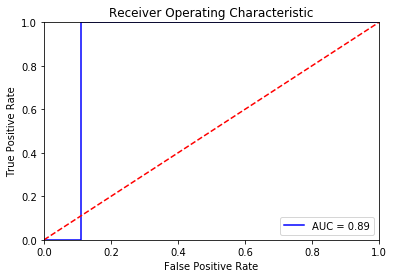

In [720]:
fpr, tpr, threshold = roc_curve(y_test, model.predict_proba(X_test)[:, 1])

roc_auc = auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Confusion matrix, without normalization
[[7 2]
 [0 1]]


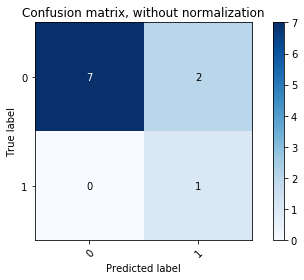

In [721]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
#     classes = classes[unique_labels(y_true.astype('int64'), y_pred.astype('int64'))]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

plot_confusion_matrix(y_test, model.predict_proba(X_test)[:, 1]> 0.19, classes=[0, 1],
                      title='Confusion matrix, without normalization')
plt.show()

Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.50')

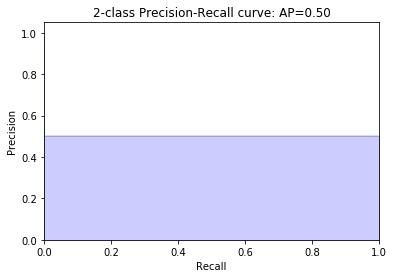

In [722]:
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))